# Alignment with bigstream

BigStream stands for "Big Sequential Transcriptomics REgistration AutoMation" and was developed to perform affine and deformable alignment between rounds of sequential multi-plexed fluorescent in situ hybridization of large samples imaged using expansion microscopy. However, it can be used for affine and deformable alignment of any pair of very large images. BigStream uses big data tools like Zarr, N5, and DASK to enable working with too-large-for-memory datasets and to make costly alignments finish in practical amounts of time by distributing the work over as many cpu cores as you are willing to allocate on your workstation or cluster.

This tutorial will walk you through the following steps:

    1. Reading image data and metadata using Zarr
    2. Computing a global affine alignment and inspecting the result
    3. Computing local affine alignments and inspecting the results
    4. Computing local deformable alignments on high resolution data and inspecting results

## Preliminary
Make sure BigStream is installed in your python environment; installation instructions are here.

You should also get the source code, which is located here. Follow the instrucions on github to clone the repository. The repository contains the example data used for this tutorial.

### Suppressing FutureWarnings and UserWarnings

DASK and Numpy will return a few expected warnings that can clutter up this tutorial. If you want to suppress them, run the following cell. Of course, feel free to leave them on if you're curious.

In [4]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

## Accessing the tutorial data

In the BigStream repository the tutorial_data folder contains two images in N5 format. We will first access the data and metadata in these files using the Zarr library, which was installed with BigStream.

In [5]:
# import library for reading
import zarr

# file paths to tutorial data N5 files
fix_path = '/groups/scicompsoft/home/fleishmang/source/bigstream/tutorial_data/fix.n5'
mov_path = '/groups/scicompsoft/home/fleishmang/source/bigstream/tutorial_data/mov.n5'

# create Zarr file object using N5Stores
fix_zarr = zarr.open(store=zarr.N5Store(fix_path), mode='r')
mov_zarr = zarr.open(store=zarr.N5Store(mov_path), mode='r')

### Metadata

The Zarr file objects are just lazy wrappers around all the data in the N5 file, so no image data has been loaded into memory yet. The first alignment step, global affine, is only meant to ensure the datasets are largely located on top of one another. This means for now we only need to grab data and metadata from a lower resolution scale level.

In [6]:
# we'll need numpy now
import numpy as np

# get pointers to the low res scale level
# still just pointers, no data loaded into memory yet
fix_lowres = fix_zarr['/dapi/lowres']
mov_lowres = mov_zarr['/dapi/lowres']

# we need the voxel spacings for the low res data sets
# we can compute them from the low res data set metadata
fix_meta = fix_lowres.attrs.asdict()
mov_meta = mov_lowres.attrs.asdict()
fix_lowres_spacing = np.array(fix_meta['pixelResolution']) * fix_meta['downsamplingFactors']
mov_lowres_spacing = np.array(mov_meta['pixelResolution']) * mov_meta['downsamplingFactors']

# sanity check: print the voxel spacings
print(fix_lowres_spacing, mov_lowres_spacing)

[1.84 1.84 1.68] [1.84 1.84 1.68]


## Global affine alignment

Since global affine alignment only uses low resolution data, we can read the full datasets into memory:

In [7]:
# read data into memory as numpy arrays
# Why transpose? zarr reads data as zyx, but we prefer xyz (e.g. metadata is already xyz)
fix_lowres_data = fix_lowres[...].transpose(2, 1, 0) 
mov_lowres_data = mov_lowres[...].transpose(2, 1, 0)

Computing the global affine with BigStream is just one function call. It will take a little while to complete, something around 5 minutes. Keep an eye on the notebook kernel status. It's finished when it changes from `Busy` to `Idle`.

In [8]:
# now we'll use bigstream
from bigstream import affine

# see next section for explanation of the parameters
global_affine = affine.dog_ransac_affine(
    fix_lowres_data, mov_lowres_data, fix_lowres_spacing, mov_lowres_spacing,
    cc_radius=8, nspots=2000, match_threshold=0.75, align_threshold=2.5,
)

 Behind the scenes, the affine is computed using these steps:

    1. Feature point extraction from fixed and moving images using a difference of Gaussians filter
    2. Correspondence matching between points in the fixed and moving point sets using correlation
    3. Affine alignment using a RANSAC filter on the point correspondences

In [11]:
# sanity check: print the result
print(global_affine)

# should be:
# [[ 9.85517677e-01 -1.59194947e-02 -2.31359024e-03  1.97508061e+01]
#  [-1.53933556e-02  1.03602805e+00 -4.13624709e-03 -4.24515090e+01]
#  [-6.26090287e-03 -6.81793159e-03  9.76373333e-01 -2.76858994e+00]]

[[ 9.85517677e-01 -1.59194947e-02 -2.31359024e-03  1.97508061e+01]
 [-1.53933556e-02  1.03602805e+00 -4.13624709e-03 -4.24515090e+01]
 [-6.26090287e-03 -6.81793159e-03  9.76373333e-01 -2.76858994e+00]]


### More detail for the dog_ransac_affine function

What were the input parameters?

    1. fix_lowres_data: fixed image as numpy array
    
    2. mov_lowres_data: moving image as numpy array
    
    3. fix_lowres_spacing: fixed image voxel spacing in micrometers, as numpy array
    
    4. mov_lowres_spacing: moving image voxel spacing in micrometers, as numpy array
    
    5. cc_radius: feature points are matched based on correlation of the data in their neighborhoods, this is the neighborhood radius in voxels
    
    6. nspots: the maximum number of feature point pairs to use to compute the affine alignment
    
    7. match_threshold: neighborhood correlation between two feature points must exceed this value for it to be a valid match
    
    8. align_threshold: points are considered aligned by the affine if they are less than this value apart, in micrometers

What is the output?


1. global_affine: the return value is a 3x4 affine transform matrix as a numpy array; this describes correspondence between points in the fixed image and moving image.

### Applying the global affine alignment to inspect results

We want to double check that the global affine alignment did something useful, so first we apply the affine transform to the moving image:

In [12]:
# we need a new function to apply transforms
from bigstream import transform

# apply the global affine to the moving image
mov_lowres_aligned = transform.apply_global_affine(
    fix_lowres_data, mov_lowres_data,
    fix_lowres_spacing, mov_lowres_spacing,
    global_affine,
)

Now we can compare the fixed, moving, and aligned data. You may need to run this cell twice to see the figure appear:

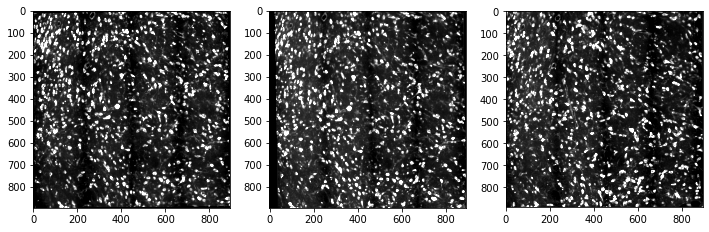

In [13]:
# we'll visualize the results with some image plots
from matplotlib import pyplot as plt
from matplotlib import cm

# plot some image slices to check on things
slc = 100
fig = plt.figure(figsize=(12,24))

fig.add_subplot(1, 3, 1)
low, high = np.percentile(fix_lowres_data[..., slc], [5, 95])
plt.imshow(fix_lowres_data[..., slc], cmap=cm.gray, vmin=low, vmax=high)

fig.add_subplot(1, 3, 2)
low, high = np.percentile(mov_lowres_aligned[..., slc], [5, 95])
plt.imshow(mov_lowres_aligned[..., slc], cmap=cm.gray, vmin=low, vmax=high)

fig.add_subplot(1, 3, 3)
low, high = np.percentile(mov_lowres_data[..., slc], [5, 95])
plt.imshow(mov_lowres_data[..., slc], cmap=cm.gray, vmin=low, vmax=high)

plt.show()

## Local affine alignments

Now we want to refine the global alignment with local alignments.

First the images are carved into overlapping blocks and a separate affine alignment is computed for each pair of blocks. The affine alignment algorithm is the same, it's just applied to each pair of local blocks instead of the entire image. When finished, the separate affines are smoothed together into a single transform for the entire moving image.

Also notice below that, even thought the affine alignment algorithm is the same, the function used for local affines is not the same one that we used for global affine alignment.

In [ ]:
local_affines = affine.dog_ransac_affine_distributed(
    fix_lowres_data, mov_lowres_aligned, fix_lowres_spacing, fix_lowres_spacing,
    cc_radius=8, nspots=2000, match_threshold=0.75, align_threshold=2.5,
    blocksize=[256,]*3, cluster_extra=["-P multifish"],
)

# sanity check, print shape of local_affines
# first three indices are over the blocks
# last two indices are the 3x4 affine matrices for each block
print(local_affines.shape)

### More detail for the dog_ransac_affine_distributed function

Note that the moving image used here is `mov_lowres_aligned`, that is the moving image after the global affine alignment. Also note that the moving voxel spacing used is `fix_lowres_spacing`. That is again because the moving image used here has already been resampled to match the fixed image.

Also note the new parameters:

1. blocksize: the size of the independent affine alignment blocks
2. cluster_extra: any extra arguments that should be given to the cluster manager

Most importantly, it would take quite some time to compute local affine transforms sequentially for each pair of blocks. The `dog_ransac_affine_distributed` function uses DASK to distribute the local affine alignment problems to a group of compute workers on your cluster or workstation that can run in parallel.

### Stitching the local affine matrices into a single smooth position field transform

If we directly applied the local affine transforms to each block, we may distort or tear the moving image along the block seams. We need to smooth the local affine transforms between the blocks. We do this by converting the local affines to position vector fields, concatenating them, and averaging in the overlap regions.

Position vector fields are large objects, so rather than store the result in memory, it will be written to disk as a zarr file and a reference to that file is returned.

In [10]:
# location on disk to store the position field data
write_path = './local_affine_position_field.zarr'

# convert local affine to position field
local_affine_position_field_zarr = transform.local_affine_to_position_field(
    fix_lowres_data.shape, fix_lowres_spacing, local_affines, write_path,
)

distributed.utils - ERROR - "('concatenate-getitem-linear_ramp_chunk-reshape-1e57f845263c9cd5912e2ac1a5a08f89', 1, 0, 2, 0)"
Traceback (most recent call last):
  File "/groups/scicompsoft/home/fleishmang/bin/miniconda3/envs/main/lib/python3.8/site-packages/distributed/utils.py", line 655, in log_errors
    yield
  File "/groups/scicompsoft/home/fleishmang/bin/miniconda3/envs/main/lib/python3.8/site-packages/distributed/scheduler.py", line 2229, in add_worker
    typename=types[key],
KeyError: "('concatenate-getitem-linear_ramp_chunk-reshape-1e57f845263c9cd5912e2ac1a5a08f89', 1, 0, 2, 0)"
distributed.core - ERROR - Exception while handling op register-worker
Traceback (most recent call last):
  File "/groups/scicompsoft/home/fleishmang/bin/miniconda3/envs/main/lib/python3.8/site-packages/distributed/core.py", line 517, in handle_comm
    result = await result
  File "/groups/scicompsoft/home/fleishmang/bin/miniconda3/envs/main/lib/python3.8/site-packages/distributed/scheduler.py", line 

KilledWorker: ("('array-fc527668eb6d5435c3f93ed240a27008', 1, 0, 1, 0, 0)", <Worker 'tcp://10.36.111.28:43101', name: 30, memory: 0, processing: 48>)

### Composing position fields

We can also convert the global affine matrix to a position field:

In [ ]:
# location on disk to store the position field data
write_path = './global_affine_position_field.zarr'

# convert global affine to position field
global_affine_position_field_zarr = transform.global_affine_to_position_field(
    fix_lowres_data.shape, fix_lowres_spacing, global_affine, write_path,
)

Eventually, we would like only one transform. So, let's combine the global and local affine position fields:

In [ ]:
# location on disk to store the position field data
write_path = './total_affine_position_field.zarr'

# compose the global affine with the local affine
total_affine_position_field_zarr = transform.compose_position_fields(
    [local_affine_position_field_zarr, global_affine_position_field_zarr,],
    fix_lowres_spacing, write_path,
)

### Applying the total affine alignment to inspect results

We want to double check that the total affine alignment does something useful, so first we apply the transform to the moving image:

In [ ]:
# location on disk to store the total affine aligned data
write_path = './total_affine_aligned.zarr'

# apply the total affine transform to the data
total_affine_aligned_zarr = transform.apply_position_field(
    mov_lowres_data, mov_lowres_spacing,
    fix_lowres_data, fix_lowres_spacing,
    total_affine_position_field_zarr,
    write_path,
)

Now we can compare the fixed, moving, and aligned data. You may need to run this cell twice to see the figure appear:

In [ ]:
# plot some image slices to check on things
slc = 100
fig = plt.figure(figsize=(12,24))

fig.add_subplot(1, 3, 1)
low, high = np.percentile(fix_lowres_data[..., slc], [5, 95])
plt.imshow(fix_lowres_data[..., slc], cmap=cm.gray, vmin=low, vmax=high)

fig.add_subplot(1, 3, 2)
low, high = np.percentile(total_affine_aligned_zarr[..., slc], [5, 95])
plt.imshow(total_affine_aligned_zarr[..., slc], cmap=cm.gray, vmin=low, vmax=high)

fig.add_subplot(1, 3, 3)
low, high = np.percentile(mov_lowres_data[..., slc], [5, 95])
plt.imshow(mov_lowres_data[..., slc], cmap=cm.gray, vmin=low, vmax=high)

plt.show()

## Local deformable alignments

Now we're ready for the final refinement: local deformable alignment. This step is meant to align the data at a finer resolution, so we use the highres scale level:

In [ ]:
# use high res data for deformable alignment
fix_highres = fix_zarr['/dapi/highres']  # still lazy
mov_highres = mov_zarr['/dapi/highres']

# get metadata associated with high res data
fix_highres_attrs = fix_highres.attrs.asdict()
mov_highres_attrs = mov_highres.attrs.asdict()
fix_highres_spacing = np.array(fix_highres_attrs['pixelResolution']) * fix_highres_attrs['downsamplingFactors']
mov_highres_spacing = np.array(mov_highres_attrs['pixelResolution']) * mov_highres_attrs['downsamplingFactors']

We'll need a copy of the high res moving image with the total affine transform applied:

In [ ]:
# location on disk to store the highres total affine aligned image
write_path = './total_affine_aligned_highres.zarr'

# apply the total affine transform to the data
total_affine_aligned_highres_zarr = transform.apply_position_field(
    mov_highres, mov_highres_spacing,
    fix_highres, fix_highres_spacing,
    total_affine_position_field_zarr, write_path,
    transform_spacing=fix_lowres_spacing, transpose=[True, True, False],
)

In [ ]:
from bigstream import deform

write_path = './local_deformation_position_field.zarr'

local_warps = deform.deformable_align_distributed(
    fix_highres, total_affine_aligned_highres_zarr,
    fix_highres_spacing, fix_highres_spacing, write_path,
    cc_radius=12, gradient_smoothing=[3., 0., 1., 2.], field_smoothing=[.5, 0., 1., 6.],
    iterations=[2, 1], shrink_factors=[2, 1], smooth_sigmas=[4, 2], step=1.0,
    cluster_extra=["-P multifish"],
    transpose=True,
)

distributed.scheduler - CRITICAL - Tried writing to closed comm: {'op': 'lost-data', 'key': "('getitem-ed579058b520fdf245cbd5928ac7a2a7', 3, 0, 0, 0)"}
distributed.scheduler - CRITICAL - Tried writing to closed comm: {'op': 'lost-data', 'key': "('getitem-5bedd6a4a5d0876566d579ae3c17f04a', 3, 1, 3, 0)"}
distributed.scheduler - CRITICAL - Tried writing to closed comm: {'op': 'task-erred', 'key': "('getitem-52d652dbbc51f5e2c59fbc5e88ebfa7a', 2, 0, 0, 0)", 'exception': b'\x80\x04\x95?\x03\x00\x00\x00\x00\x00\x00\x8c\x15distributed.scheduler\x94\x8c\x0cKilledWorker\x94\x93\x94\x8c6(\'array-6656c210841a2640b299f04181988939\', 1, 1, 0, 0)\x94h\x00\x8c\x0bWorkerState\x94\x93\x94)\x81\x94N}\x94(\x8c\x07_actors\x94\x8f\x94\x8c\x08_address\x94\x8c\x18tcp://10.36.111.26:40191\x94\x8c\n_bandwidth\x94GA\x97\xd7\x84\x00\x00\x00\x00\x8c\x06_extra\x94}\x94\x8c\t_has_what\x94\x8f\x94\x8c\x05_hash\x94\x8a\x08\r\xce\x82\x9dU\xbd\xc0\xf2\x8c\n_last_seen\x94K\x00\x8c\x10_local_directory\x94\x8c5/scratch/fle